# Recommender system

## Datasets: MovieLens

Dataset [grouplens](https://grouplens.org/datasets/movielens/) from the University of Minnesota based on their previous work released:

F. Maxwell Harper and Joseph A. Konstan. 2015. **The MovieLens Datasets: History and Context**. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

Guillermo Altesor

---



In [63]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
from datetime import datetime

%matplotlib inline

In [64]:

urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')


Descargando el conjunto de datos...
Descargado! Numero de elementos descargados b'943 users\n1682 items\n100000 ratings\n'


In [65]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

rating_df = pd.read_csv('ml-100k/u.data', sep='\t', 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                        parse_dates=['timestamp'], 
                        date_parser=dateparse)

movie_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('ml-100k/u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

#Exploratory Data Analysis (EDA)

### movie_df

In [66]:
movie_df.sample(5)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
759,760,Screamers (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Screamers%20(...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
436,437,Amityville 1992: It's About Time (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Amityville%20...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
311,312,Midnight in the Garden of Good and Evil (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Midnight+in+t...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
237,238,Raising Arizona (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Raising%20Ari...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,397,Striking Distance (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Striking%20Di...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that release_date has a date format that is not correct so we should change it, on the other hand, the NaN number in video_relase_date we should investigate and, finally, it seems that the imbd_url column is not going to work for our model.

In [67]:
movie_df.release_date = pd.to_datetime(movie_df.release_date)

In [68]:
movie_df.sample(5)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
519,520,"Great Escape, The (1963)",1963-01-01,NaN,http://us.imdb.com/M/title-exact?Great%20Escap...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
443,444,"Blob, The (1958)",1958-01-01,NaN,"http://us.imdb.com/M/title-exact?Blob,%20The%2...",0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
687,688,Leave It to Beaver (1997),1997-08-22,NaN,http://us.imdb.com/M/title-exact?Leave+It+To+B...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1317,1318,Catwalk (1995),1996-06-07,NaN,http://us.imdb.com/Title?Catwalk+(1995/I),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,622,Swiss Family Robinson (1960),1960-01-01,NaN,http://us.imdb.com/M/title-exact?Swiss%20Famil...,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


We will check the NaN with the following formula:

In [69]:
def check_nan_percent(df):
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

In [70]:
check_nan_percent(movie_df)

,null_percent,total_null
release_date,0.059453,1
video_release_date,100.000000,1682
imdb_url,0.178359,3


In [71]:
movie_df.drop(columns=['video_release_date', 'imdb_url'], inplace=True)
movie_df.release_date.fillna(value=movie_df.release_date.median(), inplace=True)

check_nan_percent(movie_df)

,null_percent,total_null


In [72]:
movie_df["year"] = movie_df['release_date'].apply(lambda x: str(x).split('-')[0])

In [73]:
movie_df.sample(5)

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western,year
672,673,Cape Fear (1962),1962-01-01,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1962
1204,1205,"Secret Agent, The (1996)",1996-11-08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1996
569,570,Wyatt Earp (1994),1994-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1994
692,693,Casino (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
776,777,Castle Freak (1995),1995-01-01,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1995


- Removed 'imbd_url' and 'video_release_date'
- We have changed date format in 'release_date'
- We fill null value in 'release_date' with the average date
- We have created the 'year' column

### raing_df

In [74]:
rating_df.sample(6)

,user_id,movie_id,rating,timestamp
64997,38,288,5,1998-04-13 00:43:08
74212,499,143,3,1998-01-23 23:42:41
91363,933,578,1,1997-09-22 14:40:30
83268,930,300,4,1997-11-14 19:23:12
94403,658,628,3,1997-09-25 00:04:01
7972,60,633,4,1997-12-28 16:36:35


In [75]:
rating_df.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [76]:
check_nan_percent(rating_df)

,null_percent,total_null


-  All correct

### user_df

In [77]:
user_df.sample(5)

,user_id,age,gender,occupation,zip_code
255,256,35,F,none,39042
181,182,36,M,programmer,33884
430,431,24,M,marketing,92629
614,615,38,M,educator,27705
6,7,57,M,administrator,91344


We'll use uszipcode to convert them to 'city' so they make sense.

In [78]:
pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from uszipcode import SearchEngine
from uszipcode import SimpleZipcode

In [80]:
from wordcloud import WordCloud

In [81]:
search = SearchEngine(simple_zipcode=True)
user_df['city'] = user_df.zip_code.apply(lambda zip: search.by_zipcode(zip).major_city)

Exception ignored in: <function SearchEngine.__del__ at 0x7f8479630f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/uszipcode/search.py", line 195, in __del__
    if self.ses:
AttributeError: 'SearchEngine' object has no attribute 'ses'


TypeError: ignored

In [83]:
user_df['age_group'] = user_df.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))
user_df.sample(5)

,user_id,age,gender,occupation,zip_code,age_group
809,810,55,F,other,80526,Midlife
314,315,31,M,educator,18301,Young
343,344,30,F,librarian,94117,Young
36,37,23,M,student,55105,Young
109,110,19,M,student,77840,Teenager


- We create age groups 'age_group'

## Finding Insights

- We create joins of the df:

In [84]:
rating_user_df = rating_df.join(other=user_df, how='inner', on='user_id', lsuffix='_R')
rating_user_movie_df = rating_user_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')
rating_movie_df = rating_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')

### Most common genres

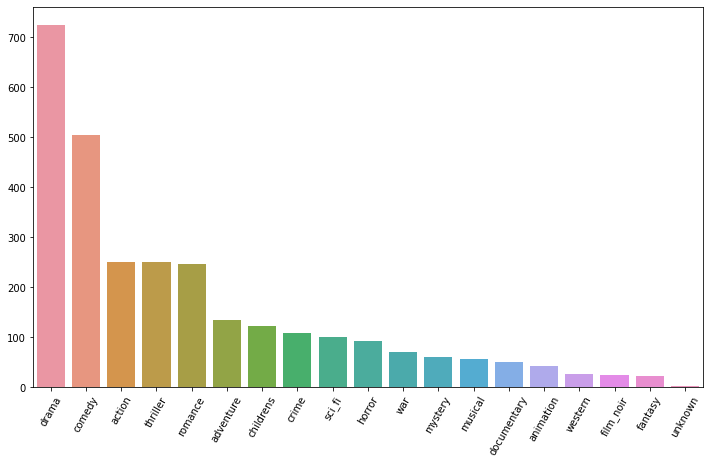

In [85]:
generes = ['unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
       'romance', 'sci_fi', 'thriller', 'war', 'western']

plt.figure(figsize=(12,7))
genere_counts = movie_df.loc[:,generes].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=60);

### Who watches more movies

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


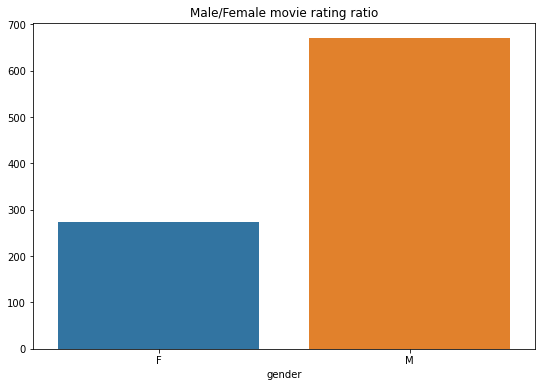

In [86]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('gender').size().index, user_df.groupby('gender').size().values)
plt.title('Male/Female movie rating ratio');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


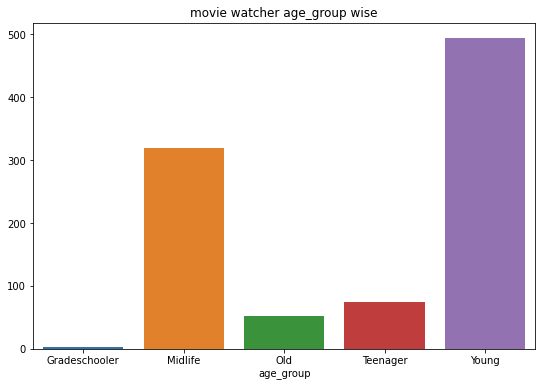

In [87]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('age_group').size().index, user_df.groupby('age_group').size().values)
plt.title('movie watcher age_group wise');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


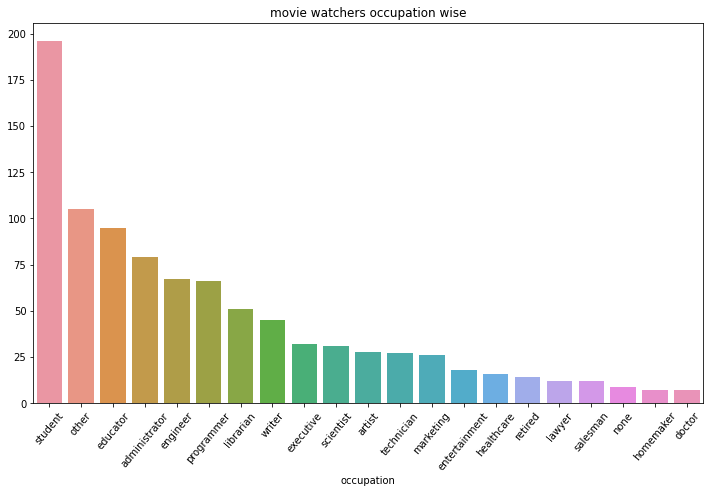

In [88]:
plt.figure(figsize=(12,7))
movie_watcher_occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(movie_watcher_occupants.index, movie_watcher_occupants.values)
plt.title('movie watchers occupation wise')
plt.xticks(rotation=50);

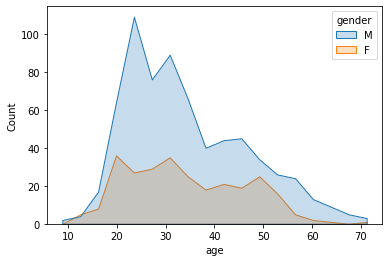

In [89]:
# age distribution by sex
sns.histplot(user_df, x="age", hue="gender", element="poly")

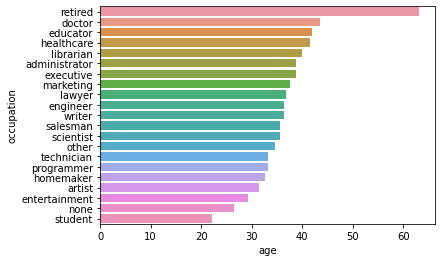

In [90]:
data = user_df.groupby("occupation")["age"].mean()
data = data.reset_index().sort_values("age", ascending=False)
sns.barplot(y="occupation",x="age", data=data)

##### Movie Rating

In [91]:
rating_df.groupby(rating_df.timestamp.dt.year).size()

timestamp
1997    52899
1998    47101
dtype: int64

In [92]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'gender']).size()

timestamp  gender
1997       F         18311
           M         34550
1998       F         11474
           M         35497
dtype: int64

- occupations with the highest activity on the platform

In [93]:
user_df.groupby("occupation")["age"].count().sort_values(ascending=False)

occupation
student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: age, dtype: int64

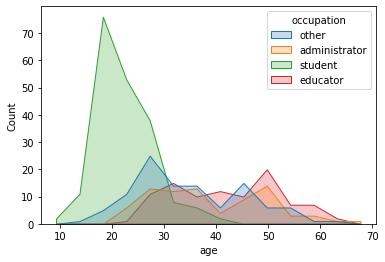

In [94]:
common_users = user_df[user_df["occupation"].isin(["student", "other","educator",'administrator'])]
sns.histplot(common_users, x="age", hue="occupation", element="poly")

- distribution of our items by gender.

In [95]:
df = movie_df[generes].sum().sort_values(ascending=False)
df

drama          725
comedy         505
action         251
thriller       251
romance        247
adventure      135
childrens      122
crime          109
sci_fi         101
horror          92
war             71
mystery         61
musical         56
documentary     50
animation       42
western         27
film_noir       24
fantasy         22
unknown          2
dtype: int64

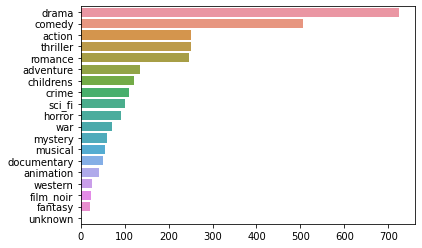

In [96]:
x = df.tolist()
y = df.index.tolist()
sns.barplot(x=x,y=y)

- Movie Rating

In [97]:
movie_df

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western,year
0,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998
1678,1679,B. Monkey (1998),1998-02-06,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1679,1680,Sliding Doors (1998),1998-01-01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998
1680,1681,You So Crazy (1994),1994-01-01,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1994


In [98]:
titles = movie_df[['movie_title', 'movie_id']]
df = pd.merge(rating_df, titles, on='movie_id')
df.groupby('movie_title')['rating'].count().sort_values(ascending=False).head(10)

movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

We will see that the most popular movies may not be the best rated.

In [99]:
df.groupby('movie_title')['rating'].mean().sort_values(ascending=False).head(10)

movie_title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

#SR Choice:

Simple:
- Popularity_based_recomender (most views and ratings that the user has not seen)
- Favorite_movies + find_similar (best valued by the user + cosine/Jaccard/Pearson similarity of those movies with others not seen)
- Favorite_movies + Content_based_recomender (best rated by the user + similar movies)
---
Memory:
- Find_similar_users + User Based Collaborative Filetering (recommender_ubcf)
- Find_similar-items + Items Vased Collaborative Filtering (recommender_ibcf)
---
Models (predict what a user would rate high):
- SVD
- Neural Network + NearestNeighbors
- Trees (OneHotEncoder + xgboost_recommender)
-Hybrid

- We will first design a model based on neural networks and then one based on XGBoost, to obtain an expected rating for those cases in which the data is not available, and unify them. Neural networks work very well when the data shows some continuity, but when we are dealing with discrete or categorical data, decision trees can show a significant advantage. That is why this combination is complementary and will help us to create a good recommendation for both users with little activity and with a lot.

## Neural Network SR

In [100]:
# Copy our scores dataset
df = rating_df

# Encrypt user identifiers
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(rating_df["user_id"].unique())

# We encode the identifiers of the items
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(rating_df["movie_id"].unique())

# And add them to the dataset
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [101]:
# Range of values for ratings
min_rating = 1.0
max_rating = 5.0

# Input data for our network
x = df[["user", "movie"]].values

# We normalize the ratings between 0 and 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# We make the separation between training and validation
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

With this we will be able to propose our base class that will be in charge of managing the model and being invoked during the training process.

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):
    """
    Clase que codifica un modelo tipo como red de recomendación
    """
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Size of our rendering models (embedding)
        self.num_users = num_users
        self.num_movies = num_movies

        # Representation of users
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        # Item Representation
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1) # Bias

    # Function that is called with an input type
    def call(self, inputs):
        # User
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Item
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        # Input vector for the network (user + item + bias)
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        # We apply a sigmoid function to evaluate the rating (0 to 1.0)
        return tf.nn.sigmoid(x)

With our neural structure raised, we simply have to instantiate the model indicating what the loss functions will be and the optimizer to use when we train the network.

We will select [BinaryCrossEntropy](https://keras.io/api/losses/probabilistic_losses/) as the function that will evaluate the goodness of our model; and [Adam](https://keras.io/api/optimizers/adam/) as the optimizer function in our exercise, but these parameters can always be varied taking into account the characteristics of our problem to be solved.

In [103]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

Having defined our model, it only remains to adjust it based on our data set.

In [104]:
batch_size = 64 # Numero de muestras por lote a emplear en el entrenamiento
epochs = 5 # Iteraciones sobre el conjunto de datos

# Procedemos a entrenar el modelo
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6513 - val_loss: 0.6366
Epoch 2/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6273 - val_loss: 0.6281
Epoch 3/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6193 - val_loss: 0.6202
Epoch 4/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6172 - val_loss: 0.6184
Epoch 5/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6170 - val_loss: 0.6184


Si todo ha ido bien, deberíamos ver cierta convergencia en el error en base al número de épocas empleado.

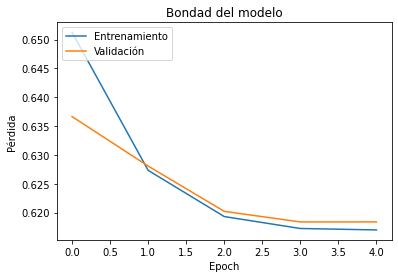

In [105]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()


Con este modelo es sencillo poder componer una función encargada de obtener las películas no vistas con mejor puntuación para un usuario concreto.

In [106]:
def nn_recommender(user_id, num=10):
 
  # Peliculas vistas
  seen_movies = rating_df[rating_df["user_id"] == user_id]

  # Películas no vistas
  not_seen = movie_df[~movie_df["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]

  # Decode
  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  return movie_df[movie_df["movie_id"].isin(movie_id)]["movie_title"]

In [124]:
nn_recommender(281)

11           Usual Suspects, The (1995)
49                     Star Wars (1977)
63     Shawshank Redemption, The (1994)
173      Raiders of the Lost Ark (1981)
317             Schindler's List (1993)
407               Close Shave, A (1995)
426        To Kill a Mockingbird (1962)
482                   Casablanca (1942)
602                  Rear Window (1954)
656    Manchurian Candidate, The (1962)
Name: movie_title, dtype: object

In [125]:
nn_recommender(3)

11                 Usual Suspects, The (1995)
97           Silence of the Lambs, The (1991)
99                               Fargo (1996)
126                     Godfather, The (1972)
312                            Titanic (1997)
314                          Apt Pupil (1998)
315                 As Good As It Gets (1997)
356    One Flew Over the Cuckoo's Nest (1975)
653                          Chinatown (1974)
656          Manchurian Candidate, The (1962)
Name: movie_title, dtype: object

## Arbol SR

Codificación del contexto:

Incluiremos información relativa a la ocupación y sexo de los usuarios de nuestro conjunto de datos de modo que esto ayude a refinar nuestras ponderaciones en las variables categóricas. Para ello podremos valernos de las funciones [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehot#sklearn.preprocessing.OneHotEncoder) y [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de *sklearn*.

In [114]:
from sklearn import preprocessing

# Obtengamos categorías de sexo y occupación para nuestros usuarios
occupation_cols = user_df["occupation"].unique().tolist()
user_df[occupation_cols] = preprocessing.OneHotEncoder(sparse = False).fit_transform(user_df["occupation"].to_numpy().reshape(-1,1))
user_df['gender'] = preprocessing.LabelEncoder().fit_transform(user_df['gender'])

# Obtengamos nuestro conjunto de datos de entrenamiento
x = rating_df[['user_id', 'movie_id']]
y = rating_df['rating']

selected_cols = occupation_cols + ["user_id", "age",'gender']
x = x.merge(user_df[selected_cols], on=["user_id","user_id"]).merge(movie_df[generes + ["movie_id"]], on=["movie_id","movie_id"])
x

,user_id,movie_id,technician,other,writer,executive,administrator,student,lawyer,educator,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,196,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Modelos ensemble


Emplearemos el modelo de [XGBoost](https://xgboost.readthedocs.io/en/stable/#).

Este modelo se compone de conjuntos de árboles de decisión y podemos emplearlo nuevamente para obtener un rating esperado para aquellos casos en los que los datos no se encuentren disponibles (items no valorados).

Seleccionaremos el conjunto de datos a emplear en entrenamiento (90%) frente al de validación (10%).

In [115]:
idx = int(0.9 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [116]:
import xgboost as xgb

# Configuramos el modelo en su versión de regressión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

# Realizamos las prediciones sobre el conjunto de validación
pred = model_xgb.predict(x_val)
rmse = np.sqrt(np.mean((pred - y_val.to_numpy())**2))
print(f'RMSE sobre el rating basado en el contenido = {rmse}')

RMSE sobre el rating basado en el contenido = 1.1299110124868725


In [119]:
def xgb_recommender(user_id, num=10):
  # Peliculas vistas
  seen_movies = rating_df[rating_df["user_id"] == user_id]

  # Películas no vistas
  not_seen = movie_df[~movie_df["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = user_df[user_df["user_id"] == user_id][selected_cols]
  movie_data = movie_df[movie_df["movie_id"].isin(not_seen)][generes + ["movie_id"]]

  # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "score" : pred_xgb})
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()

  # Devolvemos la lista de las películas mejor valoradas
  return movie_df[movie_df["movie_id"].isin(top_rated)]["movie_title"]

In [126]:
xgb_recommender(220)

71                                Mask, The (1994)
1035                         Drop Dead Fred (1991)
1546                              Show, The (1995)
1560    Tigrero: A Film That Was Never Made (1994)
1575                Hungarian Fairy Tale, A (1987)
1584                         American Dream (1990)
1593                                Everest (1998)
1614                     Warriors of Virtue (1997)
1628                              Nico Icon (1995)
1640                               Dadetown (1995)
Name: movie_title, dtype: object

## Modelo híbrido

In [121]:
def hybrid_recommender(user_id, num=10):

  """
  Combinamos los dos modelos anteriormente entrenados para poder así 
  combinar los resultados y mejorar nuestras predicciones.
  """
  # Peliculas vistas
  seen_movies = rating_df[rating_df["user_id"] == user_id]

  # Películas no vistas
  not_seen = movie_df[~movie_df["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # Empleamos la red neuronal en primera instancia
  not_seen_enc = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen_enc = [[movie2movie_encoded.get(x)] for x in not_seen_enc]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen_enc), not_seen_enc))
  pred_ratings = model.predict(input_data).flatten()

  # Montamos un DataFrame
  nn_df = pd.DataFrame({"movie_id" : not_seen, "nn_score" : pred_ratings})

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = user_df[user_df["user_id"] == user_id][selected_cols]
  movie_data = movie_df[movie_df["movie_id"].isin(not_seen)][generes + ["movie_id"]]

  # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  xgb_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "xgb_score" : pred_xgb})

  # Contruimos el dataframe que combine ambas puntuaciones
  ret_df = xgb_df.merge(nn_df, on=["movie_id","movie_id"])
  ret_df["score"] = (ret_df["nn_score"]+ret_df["xgb_score"])/10.0
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()

  # Devolvemos la lista de las películas mejor valoradas
  return movie_df[movie_df["movie_id"].isin(top_rated)]["movie_title"]

In [122]:
hybrid_recommender(196)

11           Usual Suspects, The (1995)
49                     Star Wars (1977)
63     Shawshank Redemption, The (1994)
97     Silence of the Lambs, The (1991)
126               Godfather, The (1972)
133                 Citizen Kane (1941)
173      Raiders of the Lost Ark (1981)
271            Good Will Hunting (1997)
510           Lawrence of Arabia (1962)
514                    Boot, Das (1981)
Name: movie_title, dtype: object

In [123]:
hybrid_recommender(5)

11           Usual Suspects, The (1995)
63     Shawshank Redemption, The (1994)
312                      Titanic (1997)
317             Schindler's List (1993)
602                  Rear Window (1954)
650                        Glory (1989)
653                    Chinatown (1974)
654                  Stand by Me (1986)
734                 Philadelphia (1993)
735                  Shadowlands (1993)
Name: movie_title, dtype: object

In [127]:
%%shell
jupyter nbconvert --to html /////content/GDCA-SR_Proyecto_Hibrido.ipynb

[NbConvertApp] Converting notebook /////content/GDCA-SR_Proyecto_Hibrido.ipynb to html
[NbConvertApp] Writing 641691 bytes to /////content/GDCA-SR_Proyecto_Hibrido.html
